In [1]:
import cv2
import torch
import urllib.request
from PIL import Image
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def get_depthMap(image_data, is_path=True):

    model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
    #model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
    #model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
    midas = torch.hub.load("intel-isl/MiDaS", model_type)

    USE_GPU = True
    device = torch.device('mps') if (USE_GPU and torch.backends.mps.is_available()) else torch.device('cpu')
    #print('using device:', device)
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    
    if is_path:
        original_img = Image.open(image_data)
    else:
        original_img = image_data
    img = np.array(original_img) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            # mode="bicubic",
            # align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    output_image = Image.fromarray(output)
    output_image = output_image.convert('RGB')

    return output

In [8]:
image = Image.open("data_set/0.png")
image_depth_map = get_depthMap("data_set/0.png")
image_mask = cv2.imread("data_set/0_mask.png", cv2.IMREAD_GRAYSCALE)
closed_mask = cv2.morphologyEx(image_mask, cv2.MORPH_CLOSE, np.ones((100,100),np.uint8))

Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


128


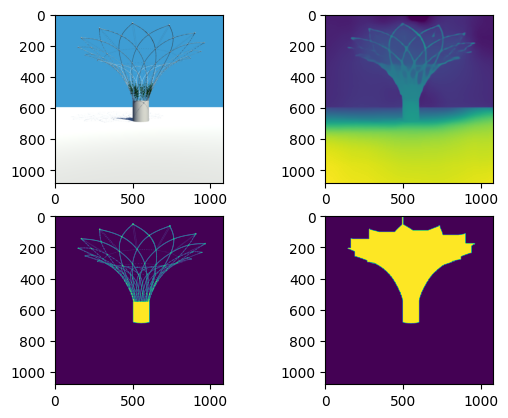

In [10]:
figure, axis = plt.subplots(2, 2)
axis[0, 0].imshow(image)
axis[0, 1].imshow(image_depth_map)
axis[1, 0].imshow(image_mask)
axis[1, 1].imshow(closed_mask)

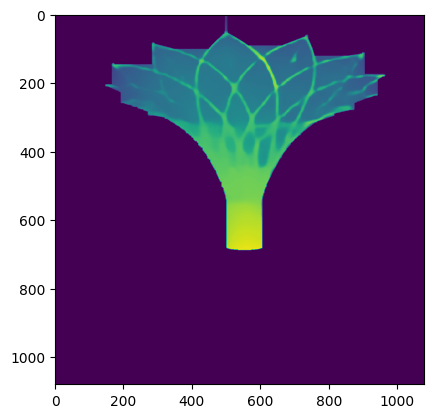

In [14]:
corolle_patch = np.zeros_like(image_depth_map)
corolle_patch[closed_mask == 255] = image_depth_map[closed_mask == 255]
plt.imshow(corolle_patch)

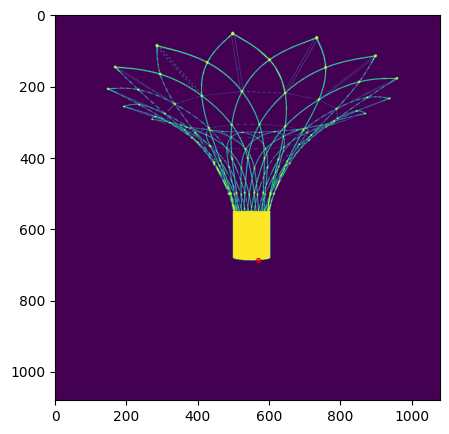

In [87]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(image_mask)
indices = np.array(np.where(image_mask == 255))
pixel = indices[:,-1]
pt = patches.Circle((index[1], index[0]), radius = 5, edgecolor = 'r', fill = False)



In [206]:
background = Image.open("backgrounds/1.jpeg")
background_map = get_depthMap("backgrounds/1.jpeg")

Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


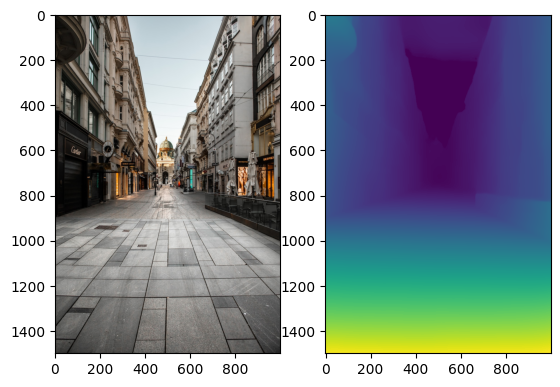

In [207]:
figure, axis = plt.subplots(1, 2)
axis[0].imshow(background)
axis[1].imshow(background_map)

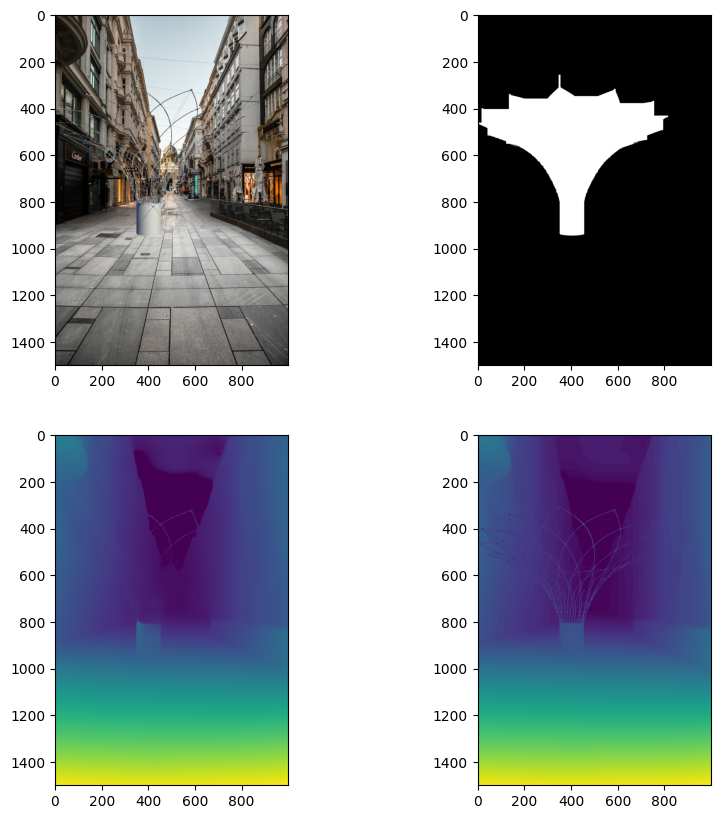

In [225]:
result = Image.open("backgrounds/1.jpeg").convert("RGBA")

mask_aux = np.repeat(image_mask[:,:, None], 4, axis=2)
corolle_mask = np.where(mask_aux == 255, 1, mask_aux)
corolle = Image.fromarray(image * corolle_mask)
result.paste(corolle, (pos_x, pos_y), Image.fromarray(image_mask))

result_mask = Image.fromarray(np.repeat(np.zeros_like(background_map)[:,:, None], 3, axis=2).astype(np.uint8))
result_mask.paste(Image.fromarray(closed_mask), (pos_x, pos_y))


result_depth_pasted = Image.fromarray(np.repeat(background_map[:,:, None], 4, axis=2).astype(np.uint8))
#corolle_depth_aux = Image.fromarray(np.repeat(image_depth_map[:,:, None], 4, axis=2).astype(np.uint8))
result_depth_pasted.paste(Image.fromarray(image_depth_map), (pos_x, pos_y), Image.fromarray(image_mask))

figure, axis = plt.subplots(2, 2, figsize=(10, 10))
axis[0, 0].imshow(result)
axis[0, 1].imshow(result_mask)
axis[1, 0].imshow(result_depth_processed)
axis[1, 1].imshow(np.array(result_depth_pasted)[:,:,0])



In [35]:
def create_example(background_image_path, corolle_image_path, corolle_mask_path, plot=True):
    hole_filler = np.ones((100,100),np.uint8)
    color_margin = 0.3
    
    print("Getting depth maps")
    background_depth = get_depthMap(background_image_path)
    corolle_depth = get_depthMap(corolle_image_path)
    
    print("Processing images")
    corolle = Image.open(corolle_image_path)
    corolle_mask = cv2.imread(corolle_mask_path, cv2.IMREAD_GRAYSCALE)
    corolle_closed_mask = cv2.morphologyEx(corolle_mask, cv2.MORPH_CLOSE, hole_filler)
    corolle_union_coord = np.array(np.where(corolle_closed_mask == 255))[:, -1]
    
    background_height, background_width = background_depth.shape
    union_color = corolle_depth[corolle_union_coord[0], corolle_union_coord[1]]
    possible_unions = np.array(np.where(abs(background_depth - union_color) < color_margin)).T
    filtered_coords = possible_unions[(possible_unions[:, 1] >= background_width/3) &
                                      (possible_unions[:, 1] <= background_width * 2/3) &
                                      (possible_unions[:, 0] >= background_height/2)]
    
    background_union_coord = filtered_coords[0]
    position = background_union_coord - corolle_union_coord
    
    print("Pasting image in position 0 (# of possible positions = {})".format(len(filtered_coords)))
    result = Image.open(background_image_path)
    mask_aux = np.repeat(corolle_mask[:,:, None], 4, axis=2)
    mask_aux = np.where(mask_aux == 255, 1, mask_aux)
    corolle = Image.fromarray(corolle * mask_aux)
    result.paste(corolle, (position[1], position[0]), Image.fromarray(corolle_mask))
    

    result_mask = Image.fromarray(np.repeat(np.zeros_like(background_depth)[:,:, None], 3, axis=2).astype(np.uint8))
    result_mask.paste(Image.fromarray(corolle_closed_mask),  (position[1], position[0]))
        
    print("Getting depth of the result image")
    result_depth = get_depthMap(result, False)
    
    print("Getting depth pasted result image")
    result_depth_pasted = Image.fromarray(np.repeat(background_depth[:,:, None], 3, axis=2).astype(np.uint8))
    result_depth_pasted.paste(Image.fromarray(corolle_depth), (position[1], position[0]), Image.fromarray(corolle_mask))

    np.save('results/images/example.npy', np.array(result))
    np.save('results/masks/example.npy', np.array(result_mask)[:, :, 0])
    np.save('results/depths/example.npy', result_depth.astype(np.uint8))
    np.save('results/depths_pasted/example.npy', np.array(result_depth_pasted)[:, :, 0])

    # result, result_maks and result_depth_pasted are 3 channel images, result_Depth is a ndarray
    return result, result_depth, result_depth_pasted, result_mask

In [36]:
result, result_depth, result_depth_pasted, result_mask = create_example("backgrounds/4.jpg", "data_set/1.png", "data_set/1_mask.png", True)

#result.save("result_1.jpg")
#result_mask.save("result_mask_1.jpg")
#cv2.imwrite('result_depth_1.jpg',result_depth)
#result_depth_pasted.save('result_depth_pasted_1.jpg')



Getting depth maps


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Processing images
Pasting image in position 0 (# of possible positions = 5400)
Getting depth of the result image


Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/icel/.cache/torch/hub/intel-isl_MiDaS_master


Getting depth pasted result image


In [37]:
def check_result(name):
    figure, axis = plt.subplots(2, 2)
    axis[0, 0].imshow(Image.fromarray(np.load("results/images/{}".format(name))))
    axis[0, 1].imshow(Image.fromarray(np.load("results/masks/{}".format(name))))
    axis[1, 0].imshow(Image.fromarray(np.load("results/depths/{}".format(name))))
    axis[1, 1].imshow(Image.fromarray(np.load("results/depths_pasted/{}".format(name))))


(1500, 2000)
(1500, 2000)
38 0 39 0


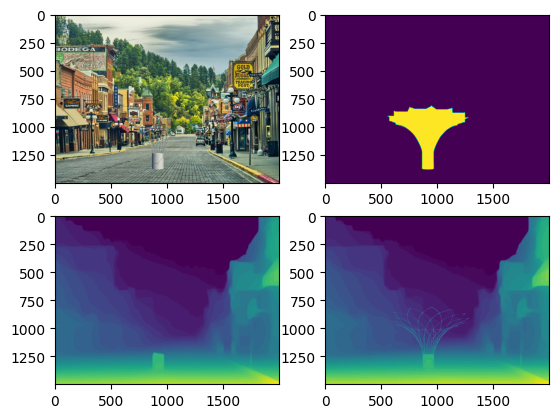

In [38]:
check_result("example.npy")


depth = np.load("results/depths/example.npy")
depth_pasted = np.load("results/depths_pasted/example.npy")

print(depth.shape)
print(depth_pasted.shape)
print(depth.max(), depth.min(), depth_pasted.max(), depth_pasted.min())